In [1]:
%matplotlib inline
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sb

In [2]:
notebook_analysis_df = pd.read_csv('mozilla-output.csv').dropna()
# which features are for analysis
list(notebook_analysis_df)

['file_name',
 'category',
 'is_code',
 'probably_uses_pyspark',
 'probably_uses_s3',
 'draws_graph',
 'has_traceback',
 'lines',
 'cell_magic',
 'line_magic',
 'line_bang']

# Apply KMeans Clustering
### Preprocessing
After we have performed our initial exploritory analysis we cluster the notebooks based on the features that we have extracted in `vectors.py`. Because clustering is sensitive to the size or unit of each feature we perform min-max scaling of the numeric features in our data frame. This is applied with the `MinMaxScaler` from sklearn.

In [3]:
from sklearn.preprocessing import MinMaxScaler
sc = MinMaxScaler()
X = notebook_analysis_df.iloc[:, 2:].values
X = sc.fit_transform(X)

### Clustering (Learning)
The clustering algorithm that was chosen for this dataset was KMeans for a starting point, because it is highly interpretable and scales well with the number of observations and the number of features.

To determine the optimal # of clusters for the dataset, we need to perform the elbow method (Raschka 2015). 

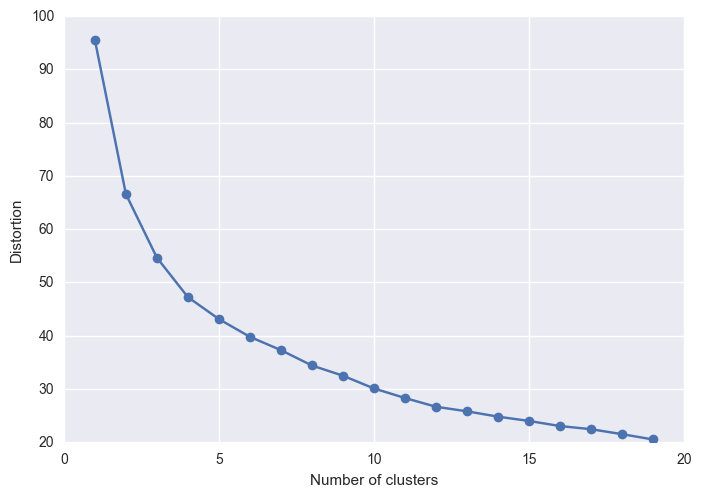

In [4]:
from sklearn.cluster import KMeans
# remove any nan's
# http://stackoverflow.com/questions/11453141/how-to-remove-all-rows-in-a-numpy-ndarray-that-contain-non-numeric-values
X = X[~np.isnan(X).any(axis=1)]

distortions = []
clusters = range(1, 20)
for i in clusters:
    km = KMeans(n_clusters=i,
               init='k-means++',
               n_init=10,
               max_iter=300,
               random_state=0)
    km.fit(X)
    distortions.append(km.inertia_)
plt.plot(clusters, distortions, marker='o')
plt.xlabel('Number of clusters')
plt.ylabel('Distortion')
plt.show()

### Elbow Method Problems
The distortion appears to decrease exponentially with no defined **elbow**. Thus, we choose 2 clusters as a best guess. (REVISIT)

In [5]:
km = KMeans(n_clusters=2,
           init='k-means++',
           n_init=10,
           max_iter=300,
           random_state=0)
# predict labels for dataframe
km.fit(X)
# subset data frame for display with notebooks and cluster
clusters = km.predict(X)

cluster_df = notebook_analysis_df.iloc[:, :].copy()
cluster_df['cluster'] = clusters

In [6]:
# print the cluster centers
centers = km.cluster_centers_

# convert to a dataframe
features=list(notebook_analysis_df)[2:]
pd.DataFrame(centers, columns=features)

,is_code,probably_uses_pyspark,probably_uses_s3,draws_graph,has_traceback,lines,cell_magic,line_magic,line_bang
0,0.961122,0.548501,0.115748,0.011215,0.045779,0.031478,0.044918,0.047113,6.938894e-18
1,0.828612,0.037008,0.018980,0.039231,0.034983,0.140317,0.010173,0.116053,4.631503e-02


### Clustering Results
After performing clustering with k = 2, we can see that we have two clusters, one for analysis w/ spark and s3 and another cluster without analysis. The other features seem to deviate less between the two clusters. 

We create a scatterplot with hue of the points as the two clusters below...

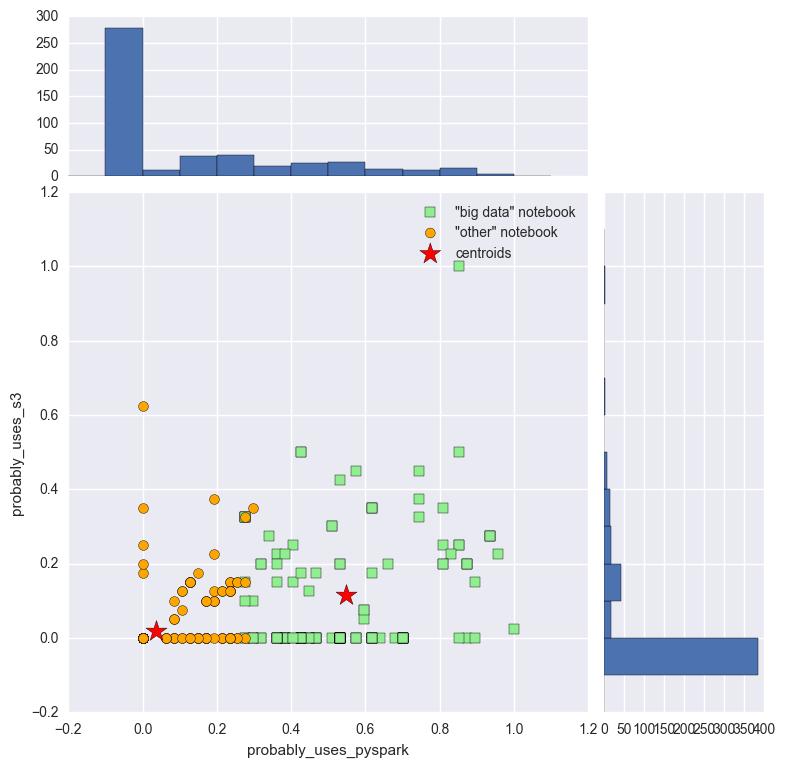

In [7]:
from matplotlib.ticker import NullFormatter
nullfmt = NullFormatter()

# spark cell prominance vs. s3 cell prominance
feature_x = 1
feature_y = 2

plt.figure(1, figsize=(8,8))

# definitions for the axes
left, width = 0.1, 0.65
bottom, height = 0.1, 0.65
bottom_h = left_h = left + width + 0.02

rect_scatter = [left, bottom, width, height]
rect_histx = [left, bottom_h, width, 0.2]
rect_histy = [left_h, bottom, 0.2, height]

axScatter = plt.axes(rect_scatter)
axHistx = plt.axes(rect_histx)
axHisty = plt.axes(rect_histy)

axHistx.xaxis.set_major_formatter(nullfmt)
axHisty.yaxis.set_major_formatter(nullfmt)

axScatter.scatter(X[clusters==0,feature_x],
            X[clusters==0,feature_y],
            s=50,
            c='lightgreen',
            marker='s',
            label='"big data" notebook')

axScatter.scatter(X[clusters==1,feature_x],
            X[clusters==1,feature_y],
            s=50,
            c='orange',
            marker='o',
            label='"other" notebook')

axScatter.scatter(centers[:,feature_x],
            centers[:,feature_y],
            s=250,
            marker='*',
            c='red',
            label='centroids')

# color based on the cluster assigned
axScatter.set_xlabel('probably_uses_pyspark')
axScatter.set_ylabel('probably_uses_s3')
axScatter.legend()

binwidth = 0.1
xymax = np.max([np.max(np.fabs(X[:, feature_x])), np.max(np.fabs(X[:, feature_y]))])
lim = (int(xymax/binwidth) + 1) * binwidth

bins = np.arange(-lim, lim + binwidth, binwidth)
axHistx.hist(X[:, feature_x], bins=bins)
axHisty.hist(X[:, feature_y], bins=bins, orientation='horizontal')

# no labels
axHistx.xaxis.set_major_formatter(nullfmt)
axHisty.yaxis.set_major_formatter(nullfmt)

axHistx.set_xlim(axScatter.get_xlim())
axHisty.set_ylim(axScatter.get_ylim())

plt.show()

note: there are a large amount of notebooks used that do not appear to contain either s3 or spark variables. this isn't that overwhelming, because notebooks that were downloaded were from mozilla employees public gists rather than any private gists that could contain sensitive information?

# Attempt at Hierarchical Clustering w/ Scipy

In [8]:
from scipy.cluster.hierarchy import linkage
row_clusters = linkage(X, method='complete', metric='euclidean')

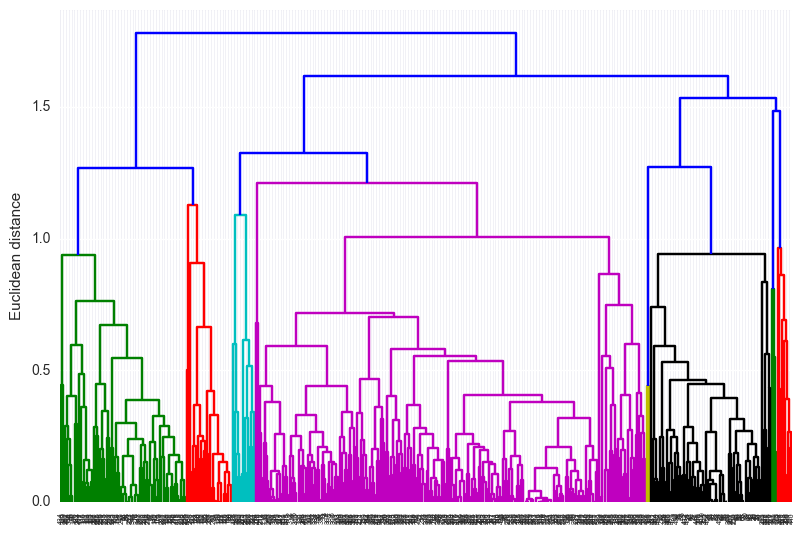

In [9]:
from scipy.cluster.hierarchy import dendrogram
row_dendr = dendrogram(row_clusters)

import matplotlib.pyplot as plt

plt.tight_layout()
plt.ylabel('Euclidean distance')
plt.show()

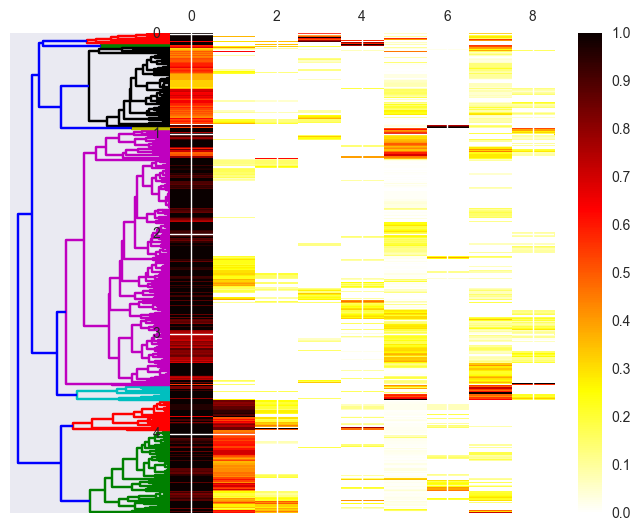

In [10]:
fig = plt.figure(figsize=(8, 8))
axd = fig.add_axes([0.09, 0.1, 0.2, 0.6])
row_dendr = dendrogram(row_clusters, orientation='left')
df_rowclust = pd.DataFrame(X[row_dendr['leaves'][::-1]], columns=features)
axm = fig.add_axes([0.29,0.1,0.6,0.6])
cax = axm.matshow(df_rowclust, interpolation='nearest', cmap='hot_r', aspect='auto')
axd.set_xticks([])
axd.set_yticks([])
for i in axd.spines.values():
    i.set_visible(False)
fig.colorbar(cax)
axm.set_yticklabels([''] + list(df_rowclust.index))
plt.show()